# Running QAOA on IQM Garnet using Cirq

IQM Garnet is a quantum computer suitable for executing algorithms using up to 20 qubits. An example is solving Max-Cut on 3-regular graphs using the Quantum Approximate Optimization Algorithm (QAOA). 

QAOA is a variational quantum algorithm designed to solve combinatorial optimization problems. 

In this notebook, we will learn how ...
* ... QAOA works.
* ... to run QAOA on IQM Garnet.
* ... to use the `iqm.qiskit-iqm` transpiler to automate quantum algorithm executions on IQM Garnet.

In order to follow this example or start experimenting with your own problems using IQM Garnet, make sure to have all packages in the appropriate version installed.

In [16]:
#%%capture
!pip install "iqm-client[cirq]"
!pip install networkx
!pip install matplotlib
!pip install pylatexenc

## Connecting to IQM Garnet via IQM Resonance

In order to access IQM Garnet through IQM Resonance, you will need to create an API Token. Go to [resonance.meetiqm.com](https://resonance.meetiqm.com), create and copy the token, execute the cell, and paste the token to store it as a environment variable (or follow the guidelines for your system to create a environment variable).

In [1]:
import os
os.environ["IQM_TOKEN"] = input()

Then we can start again by connecting IQM Resonance and create a `sampler` object that we can use later.

In [8]:
from iqm.cirq_iqm.iqm_sampler import IQMSampler

server_url="https://cocos.resonance.meetiqm.com/garnet"
sampler = IQMSampler(server_url) 

# Instead of setting the environment variable, you could add the token as an argument to the IQMProvider constructor
# sampler = IQMSampler(server_url, token=token)

## Problem instance

For the purpose of this demonstration, we will solve a MaxCut problem. MaxCut is an NP-hard problem, with applications in clustering, communication analysis, network science, and statistical physics. But it also serves as a great showcase on how quantum optimization algorithms like QAOA work. 

With MaxCut, we are given a graph, where we want to find a cut of the graph (we devide the vertices into two subset) and want to maximize the number of edges between this group. You can get a feeling for Max-Cut [here](/curriculum/applications03.html).

![MaxCutExample](../../../curriculum/curriculum/applications/example.svg)

To begin, let's choose a graph to find the maximum cut for. We generate a random regular graph with 8 nodes and a degree of 3 (n=8, d=3).

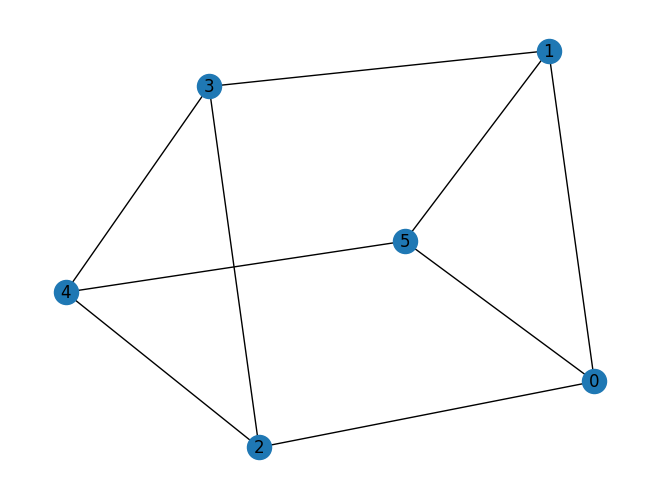

In [82]:
import networkx as nx

G = nx.random_regular_graph(d=3, n=6, seed=999)
pos = nx.spring_layout(G, seed=888)
nx.draw(G, with_labels=True, pos=pos)

## Solving MaxCut using QAOA and IQM Garnet

At the heart of the Quantum Approximate Optimization Algorithm (QAOA) is a parametrized quantum circuit designed to tackle complex optimization problems, like the Max Cut problem. The QAOA circuit is designed to efficiently explore the solution space of a given problem. It is composed of a series of alternating layers of single-qubit rotations and two-qubit interactions. By adjusting the parameters in the circuit, QAOA aims to find the optimal configuration that maximizes or minimizes a specific objective function, such as the MaxCut value in a given graph.

QAOA operates by encoding the problem into a **problem hamiltonian** whose ground state represents the optimal solution. The dynamics of the problem hamiltonian are encoded in a quantum computer by a circuit representing the **problem unitary**. Correspondingly, a circuit representing the so-called **mixer unitary** is used to explore more possible solutions to the problem. By alternating between the application of the problem unitary and the mixer unitary, QAOA evolves the quantum system toward the ground state of the problem Hamiltonian, which corresponds to the optimal solution of the combinatorial problem. 

This process is facilitated by a classical optimization loop that is minimizing the expectation value of the problem hamiltonian. Thus, helping us getting closer to its ground state.

## Problem circuit

The part of the QAOA ansatz that encodes the problem hamiltonian based on the graph we generated above is called the problem unitary or problem circuit. There we encode the edges of our graph into quantum operations. We apply ZZ rotations, parameterized by $\gamma$, to all pairs of qubits that are connected by an edge.

In [89]:
import cirq
import sympy  # Import sympy for symbolic representation
from cirq import Circuit, ParamResolver, ZZPowGate
import numpy as np

# Create Quantum Circuit
qubits = sampler.device.qubits[:6]

def create_problem_circuit(parameter, graph):
    """
    Creates a problem circuit that is part of the QAOA ansatz.
    """
    circuit = Circuit()
    for pair in list(graph.edges()):  # pairs of nodes
        circuit.append(ZZPowGate(exponent= 2 * parameter / np.pi).on(qubits[pair[0]], qubits[pair[1]]))
    return circuit

gamma = sympy.Symbol("gamma")
circ_prob = create_problem_circuit(gamma, G)
print(circ_prob)


                                                                            ┌────────────────────────────────────────────────────────┐
QB1 (d=2): ───ZZ─────────────────────────────ZZ──────────────────────────────ZZ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
              │                              │                               │
QB2 (d=2): ───ZZ^(0.636619772367581*gamma)───┼───────────────────────────────┼───────────────────────────────────────────────────────────ZZ─────────────────────────────ZZ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                             │                               │                                                           │                              │
QB3 (d=2): ───────────────────

## Mixer circuit

In order for QAOA to explore more possible solutions, we also need to create a **mixer circuit**, which increases the superpositions of our quantum state in the computational basis. This means we are less dependent on the initial state and explore more of the search space. As our mixer circuit we use parametrized single qubit gates applied to all qubits. In the language of physics, this can be interpreted as applying a transversal magnetic field to all our spins for some amount of time. 

In [90]:
def create_mixer_circuit(parameter):
    """
    Creates a mixer circuit that is part of the QAOA ansatz.
    """
    circuit = Circuit()
    for qubit in qubits:
        circuit.append(cirq.rx(2 * parameter).on(qubit))
    return circuit

beta = sympy.Symbol("beta")
circ_mixer = create_mixer_circuit(beta)
print(circ_mixer)

QB1 (d=2): ───Rx(2*beta)───

QB2 (d=2): ───Rx(2*beta)───

QB3 (d=2): ───Rx(2*beta)───

QB4 (d=2): ───Rx(2*beta)───

QB5 (d=2): ───Rx(2*beta)───

QB6 (d=2): ───Rx(2*beta)───


## Creating the QAOA ansatz

Now we can combine the **mixer circuit** with the **problem circuit** into one full quantum circuit. This combination (of mixer and problem circuit) we call a **layer of the QAOA ansatz**. Increasing the number of layers (or the depth of the circuit), allows QAOA to explore a larger portion of the solution space. However, it also leads to more parameters to be optimized, making the algorithm computationally more expensive for the classical computer. Noise also gets added to the computation from every gate applied. Finding the optimal number of layers is often a balance between desired solution quality, the classical computational resources available, the gate fidelities and the wall-clock time available for the computation. In practice, QAOA users typically experiment with different depths to determine the most effective trade-off between runtime and solution quality for a given optimization problem.

By initializing the quantum system in a uniform superposition state, we ensure that every possible solution is equally represented when starting to explore the solution space.

In [91]:
# Create a new circuit
circ_qaoa = Circuit()

# First, we define the initial state preparation step
for qubit in qubits:
    circ_qaoa.append(cirq.H(qubit))

# Then we combine the previous circuits using the append() method:
circ_qaoa.append(circ_prob)
circ_qaoa.append(circ_mixer)


# Then we combine the previous circuits using again the append() method:
delta = sympy.Symbol("delta")
epsilon = sympy.Symbol("epsilon")
circ_mixer_layer_2 = create_mixer_circuit(delta)
circ_prob_layer_2 = create_problem_circuit(epsilon, G)
circ_qaoa.append(circ_prob_layer_2)
circ_qaoa.append(circ_mixer_layer_2)

# Add measurement
circ_qaoa.append(cirq.measure(*qubits, key='m'))

# Draw the circuit
print(circ_qaoa)

                                                                                ┌────────────────────────────────────────────────────────┐                                                                                                                                                                                                                                             ┌────────────────────────────────────────────────────────────┐
QB1 (d=2): ───H───ZZ─────────────────────────────ZZ──────────────────────────────ZZ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Rx(2*beta)───ZZ───────────────────────────────ZZ────────────────────────────────ZZ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Note, IQM Garnet has 20 qubits and if fewer qubits are required, one can optimize our selection based on the fidelities of the two-qubit gates and the connectivity among the chosen subset of qubits.

Now, let's transpile our circuit for IQM Garnet and explore the outcome. Here we also use the iqm-qiskit function [`optimize_single_qubit_gates`](https://iqm-finland.github.io/qiskit-on-iqm/api/iqm.qiskit_iqm.iqm_transpilation.optimize_single_qubit_gates.html) to optimize the number of single-qubit gates in the transpiled circuit. We can provide a specific subset of qubits we want to use by handing over an `initial_layout`.

In [92]:
decomposed_circuit = sampler.device.decompose_circuit(circ_qaoa)

print(decomposed_circuit)

                                                                             ┌─────────┐                                      ┌─────────┐                                  ┌─────────────────────────────┐                            ┌──────────┐                                                                                                                                                                                                                                                                                                                                                 ┌───────────────────────────────┐                                    ┌─────────┐
QB1 (d=2): ───Y^0.5───X───────────────@──────────────────────────────────@────────────@───────────────────────────────────@────────────@────────────────────────────────────@────────────────────────────────Rx(2*beta)─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

## Evaluating possible solutions to the MaxCut problem

In order to find the best parameters $\gamma$ and $\beta$, we need to have a way that measures how "good" a solution is. This is done with the cost function. It maps each possible solution (typically a bitstring like `0100`) to a real number, typically representing the cost or energy associated with that solution. Lower values of the cost function correspond to more optimal or favorable solutions.

An easy way to do this for MaxCut is to count how many edges we cut. The more edges the better. As we want to have the optimal solution corresponding to the minimal cost, we can just multiply the number of cuts with -1, so the optimal solution maps to the lowest number.

In [40]:
def cost_function(graph, solution):
    """
    Compute the count of all edges of graph that are cut given a possible solution
    """
    solution_reverse = solution[::-1]
    cut = 0
    for i, j in list(graph.edges()):
        if solution_reverse[i] != solution_reverse[j]:
            cut += 1
    return -1 * cut

We will now iteratively improve the parameters to approximate the solution to the problem. As we will typically do more shots on a quantum computer, we will compute the expectation value of costs over one run, i.e. we average the cost over all shots. 

In [98]:
def compute_expectation_value(graph, counts): 
    """
    Computes expectation value based on measurement results
    """

    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():

        obj = cost_function(graph, bitstring)
        avg += obj * count
        sum_count += count

    return avg/sum_count

from iqm.cirq_iqm.optimizers import simplify_circuit

def create_objective_function(graph, circuit):
    """
    Creates a function that maps the parameters to the parametrized circuit, 
    runs it and computes the expectation value
    """
    def objective_function(theta):

        resolver = cirq.ParamResolver({gamma: theta[0], beta: theta[1], delta: theta[2], epsilon: theta[3]})

        routed_circuit, _, _ = sampler.device.route_circuit(circuit)

        routed_circuit_decomposed = sampler.device.decompose_circuit(routed_circuit)
        simplified_circuit = simplify_circuit(routed_circuit_decomposed)


        result = sampler.run_sweep(simplified_circuit, 
                                   repetitions=1000, 
                                   params=resolver)


        # Convert integer results to binary strings
        counts = result[0].histogram(key='m')
        num_qubits = len(qubits)
        bitstring_counts = {format(key, f'0{num_qubits}b'): value for key, value in counts.items()}


        return compute_expectation_value(graph, bitstring_counts)

    return objective_function

### Running QAOA on IQM Garnet

With now everything in place, we can finally start the classical-quantum loop and approximate the solution:

In [100]:
from scipy.optimize import minimize

expectation = create_objective_function(G, circ_qaoa)

result = minimize(expectation,
                      [1.0, -1.0, 1.0, -1.0],
                      method='COBYLA')
result

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -5.015
       x: [ 1.640e+00 -1.085e+00  1.383e+00 -1.153e+00]
    nfev: 47
   maxcv: 0.0

Of course, it's possible to keep the results of the last execution and directly use that to solve our MaxCut problem. However, for clarity and learning purposes, we will use the optimized parameters we acquired through the classical loop to run the quantum circuit one more time.

In [101]:
# Execute the circuit with the optimized parameters
optimized_parameters = result.x


resolver = cirq.ParamResolver({gamma: optimized_parameters[0], beta: optimized_parameters[1], delta: optimized_parameters[2], epsilon: optimized_parameters[3]})
routed_circuit, _, _ = sampler.device.route_circuit(circ_qaoa)
routed_circuit_decomposed = sampler.device.decompose_circuit(routed_circuit)
simplified_circuit = simplify_circuit(routed_circuit_decomposed)
result = sampler.run_sweep(simplified_circuit, repetitions=1000, params=resolver)


counts = result[0].histogram(key='m')
num_qubits = len(qubits)
bitstring_counts = {format(key, f'0{num_qubits}b'): value for key, value in counts.items()}


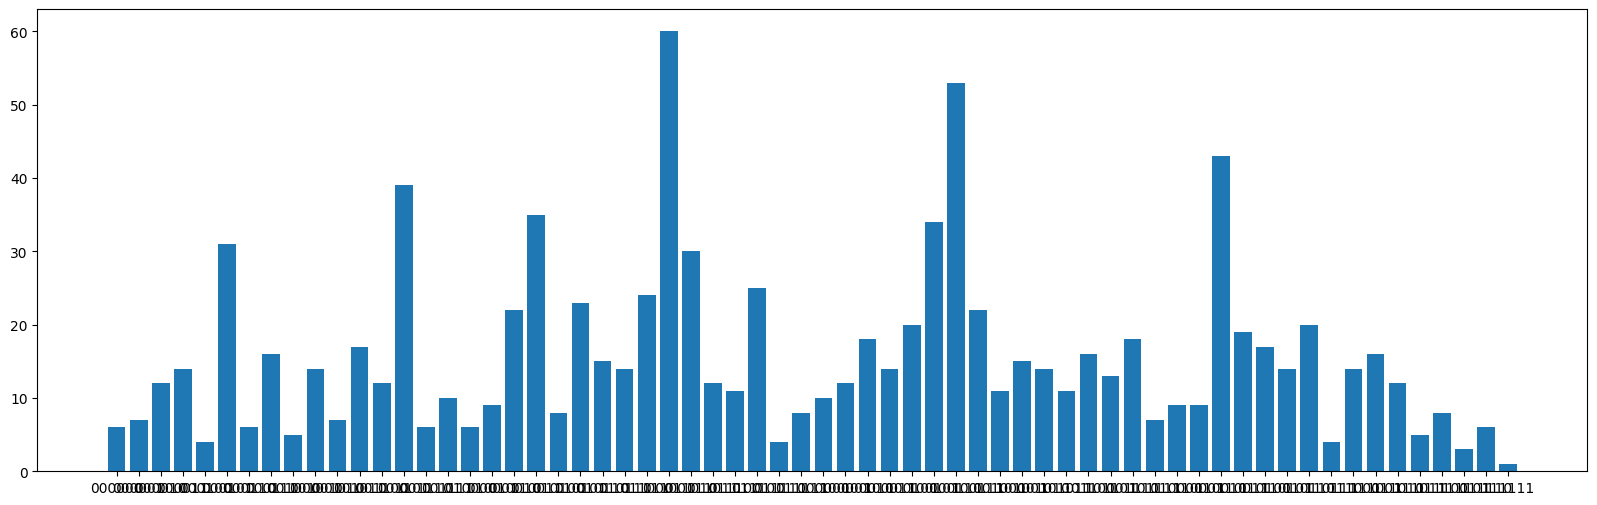

In [102]:
# Plot the results

import matplotlib.pyplot as plt
# Sort keys numerically for proper plotting
sorted_counts = dict(sorted(bitstring_counts.items()))

# Convert bitstrings to integers for plotting
x_labels = list(sorted_counts.keys())
x_values = range(len(x_labels))
y_values = list(sorted_counts.values())

# Plot histogram
fig, ax = plt.subplots(figsize=(20, 6))
ax.bar(x_values, y_values, tick_label=x_labels)

# Display plot
plt.show()

The top three results are  [('011001', 60), ('100110', 53), ('110010', 43)]
The maximum cut is given by 011001 with a cut length of 7


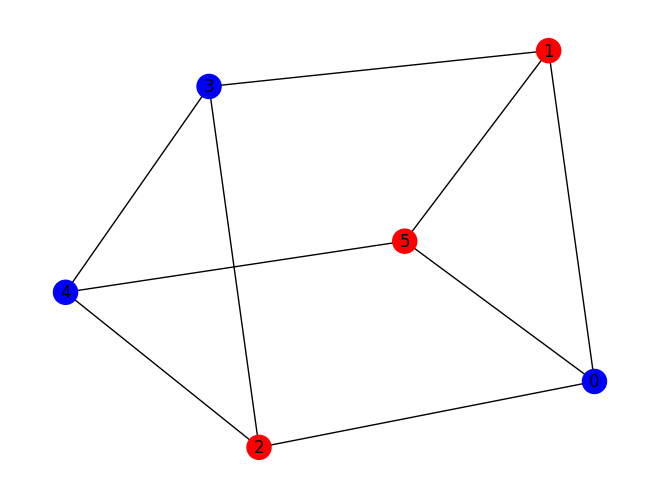

In [103]:
# Sort the counts by their values in descending order
sorted_counts = sorted(bitstring_counts.items(), key=lambda x: x[1], reverse=True)

# Get the top three results
top_three_results = sorted_counts[:3]

print("The top three results are ",  top_three_results)
results=[]
for res in top_three_results:
    results.append([cost_function(G,res[0]),res[0]])

# Get the best solution given the results of the maxcut objective function
max_cut_length, max_cut = min(results) 
print("The maximum cut is given by " + max_cut + " with a cut length of " + str(-max_cut_length))

# Apply coloring based on the solution
solution_aux = [int(x) for x in max_cut]
solution = solution_aux[::-1]

# Create a color map based on the solution
color_map = []
for node in G:
    if solution[node] == 0:
        color_map.append('red')
    else:
        color_map.append('blue')

# Draw the graph with the color map
plt.figure()
pos = nx.spring_layout(G, seed=888)
nx.draw(G, pos, node_color=color_map, with_labels=True)
plt.show()

So, we were able to run a QAOA circuit on IQM Garnet 🎉.

## Take it further

Now it's your turn. Start from the code above. Experiment with other graphs or check out IQM Garnet with completely other problems.

In [15]:

# Copyright 2024 IQM Quantum Computers (Jalil Khatibi Moqadam, Stefan Seegerer, Hermanni Heimonen)
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.